In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install -U keras-tuner

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# from keras.utils import np_utils
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.applications import DenseNet201, ResNet101V2, InceptionV3, EfficientNetB4, Xception
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
from keras.preprocessing import image
from random import shuffle
import os, os.path
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils import class_weight
import cv2
import keras_tuner as kt

In [ ]:
image_dest_dir = "/content/drive/MyDrive/SPECT_MPI_Dataset"

In [ ]:
dir_list_1 = (os.listdir(image_dest_dir))
dir_list_1

['ValidationSet', 'TestSet', 'TrainSet']

In [ ]:
valid_dir_path = image_dest_dir+'/'+dir_list_1[0]
test_dir_path = image_dest_dir+'/'+dir_list_1[1]
train_dir_path = image_dest_dir+'/'+dir_list_1[2]

In [ ]:
os.listdir(train_dir_path)

['Normal', 'Abnormal']

In [ ]:
for i in range(len(dir_list_1)):
    dir_list_2 = os.listdir(image_dest_dir+'/'+dir_list_1[i])
print(dir_list_2)


['Normal', 'Abnormal']


In [ ]:
print("\t\tTrain DataSet")
print("CT scans with normal            : " + str(len(os.listdir(train_dir_path+'/'+dir_list_2[0]))))
print("CT scans with abnormal          : " + str(len(os.listdir(train_dir_path+'/'+dir_list_2[1]))))

print("\n\t\tTest DataSet")
print("CT scans with normal            : " + str(len(os.listdir(test_dir_path+'/'+dir_list_2[0]))))
print("CT scans with abnormal          : " + str(len(os.listdir(test_dir_path+'/'+dir_list_2[1]))))

print("\n\t\tvalid DataSet")
print("CT scans with normal            : " + str(len(os.listdir(valid_dir_path+'/'+dir_list_2[0]))))
print("CT scans with abnormal          : " + str(len(os.listdir(valid_dir_path+'/'+dir_list_2[1]))))


		Train DataSet
CT scans with normal            : 28
CT scans with abnormal          : 100

		Test DataSet
CT scans with normal            : 7
CT scans with abnormal          : 25

		valid DataSet
CT scans with normal            : 7
CT scans with abnormal          : 25


In [ ]:
train_image_list = os.listdir(train_dir_path+'/'+dir_list_2[1])

w=10
h=10
fig=plt.figure(figsize=(15 , 20))
columns = 5
rows = 10
for i in range(columns*rows):
    path = train_dir_path +'/'+dir_list_2[1]+"/"+train_image_list[i]
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [ ]:
train_image_list = os.listdir(train_dir_path+'/'+dir_list_2[1])

w=10
h=10
fig=plt.figure(figsize=(15 , 20))
columns = 5
rows = 10
for i in range(1, columns*rows+1):
    path = train_dir_path+'/'+dir_list_2[1]+'/' + train_image_list[i-1]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
train_image_list = os.listdir(train_dir_path+'/'+dir_list_2[1])

w=10
h=10
fig=plt.figure(figsize=(15 , 20))
columns = 5
rows = 10
for i in range(1, columns*rows +1):
    path = train_dir_path+'/'+dir_list_2[1]+"/" + train_image_list[i-1]
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
image_width = 256
image_height = 256
if K.image_data_format() == 'channels_first':
    input_shape = (3,  image_height, image_width,)
else:
    input_shape = (image_height, image_width, 3)
input_shape

(256, 256, 3)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0, # this performs min-max normalization
    shear_range=0.20,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='constant'
)

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0, # this performs min-max normalization
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir_path,
        target_size=(image_height, image_width),
        batch_size=8,
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
        )

Found 128 images belonging to 2 classes.


In [ ]:
class_weights = class_weight.compute_class_weight(
                class_weight = 'balanced',
                classes = np.unique(train_generator.classes),
                y=train_generator.classes)
for cls in train_generator.classes:
    class_weights[cls]
class_weights_1 = { 0 : class_weights[0] , 1 : class_weights[1] }

In [ ]:
class_weights_1

{0: 0.64, 1: 2.2857142857142856}

In [ ]:
validation_generator = test_datagen.flow_from_directory(
        valid_dir_path,
        target_size=(image_height, image_width),
        batch_size=8,
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
)

Found 32 images belonging to 2 classes.


In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def fmed(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)
    fmed = 2 * (spec * sens)/(spec+sens+K.epsilon())
    return fmed

def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
def macro_f1(y_true, y_pred):
     return f1_score(y_true, y_pred, average='macro')

**Importing pre-trained models**

In [ ]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

**Model Initialization**

In [ ]:
# base_model_inception.summary()

In [ ]:
def generate_model(hp):
    opt=Adam(learning_rate=0.0001)
    base_model=base_model_inception
    model = Sequential()
    units = hp
    model.add(base_model)
    model.add(Flatten())
    for i in range(hp.Int('num_layers_dense', min_value=1, max_value=15)):
        model.add(
          Dense(hp.Int('units' + str(i), min_value=8, max_value=512),
          activation=hp.Choice('activation'+str(i), values=['relu', 'leaky_relu', 'elu', 'selu']),
          ))
        model.add(Dropout(hp.Choice('dropout'+str(i), values=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy', sensitivity, specificity, fmed, f1])
    return model

In [ ]:
tuner_inception = kt.RandomSearch(generate_model,
                        objective = 'val_accuracy',
                        max_trials=3,
                        directory="mydir1",
                        project_name="Inception")

In [ ]:
tuner_inception.search(train_generator, epochs=10, validation_data=validation_generator)

Trial 3 Complete [00h 01m 31s]
val_accuracy: 0.78125

Best val_accuracy So Far: 0.78125
Total elapsed time: 00h 04m 43s


In [ ]:
tuner_inception.get_best_hyperparameters()[0].values

{'num_layers_dense': 12,
 'units0': 160,
 'activation0': 'selu',
 'dropout0': 0.7,
 'units1': 8,
 'activation1': 'relu',
 'dropout1': 0.0,
 'units2': 8,
 'activation2': 'relu',
 'dropout2': 0.0,
 'units3': 8,
 'activation3': 'relu',
 'dropout3': 0.0,
 'units4': 8,
 'activation4': 'relu',
 'dropout4': 0.0,
 'units5': 8,
 'activation5': 'relu',
 'dropout5': 0.0,
 'units6': 8,
 'activation6': 'relu',
 'dropout6': 0.0,
 'units7': 8,
 'activation7': 'relu',
 'dropout7': 0.0,
 'units8': 8,
 'activation8': 'relu',
 'dropout8': 0.0,
 'units9': 8,
 'activation9': 'relu',
 'dropout9': 0.0,
 'units10': 8,
 'activation10': 'relu',
 'dropout10': 0.0,
 'units11': 8,
 'activation11': 'relu',
 'dropout11': 0.0}

In [ ]:
model_inception=tuner_inception.get_best_models(num_models=1)[0]

In [ ]:
num_train_samples = 128
num_validation_samples = 32
batch_size = 8

**Training Inception**

In [ ]:
history_val_fmed_inception = model_inception.fit(
    train_generator,
    steps_per_epoch= num_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps= num_validation_samples // batch_size,
    verbose=1,
    epochs=1000,
    initial_epoch=10,
    callbacks=[
        EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=20,
        verbose=1,
        mode='min',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=25
        )
    ],
    class_weight = class_weights_1
    )

Epoch 1/1000
16/16 [==============================] - 47s 427ms/step - loss: 0.6945 - accuracy: 0.7734 - sensitivity: 0.0000e+00 - specificity: 0.9896 - fmed: 0.0000e+00 - f1: 0.0000e+00 - val_loss: 0.6687 - val_accuracy: 0.7812 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_fmed: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/1000
16/16 [==============================] - 6s 350ms/step - loss: 0.6892 - accuracy: 0.7812 - sensitivity: 0.0469 - specificity: 0.9792 - fmed: 0.0641 - f1: 0.0562 - val_loss: 0.6743 - val_accuracy: 0.7812 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_fmed: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 3/1000
16/16 [==============================] - 4s 247ms/step - loss: 0.6923 - accuracy: 0.7578 - sensitivity: 0.1250 - specificity: 0.9539 - fmed: 0.1154 - f1: 0.0833 - val_loss: 0.6709 - val_accuracy: 0.7812 - val_sensitivity: 0.0000e+00 - val_specificity: 1.0000 - val_fmed: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 4/1000
16/16 [===================

**Results & Visualization**

In [ ]:
# list all data in history
history_inception = history_val_fmed_inception
history = history_inception
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'sensitivity', 'specificity', 'fmed', 'f1', 'val_loss', 'val_accuracy', 'val_sensitivity', 'val_specificity', 'val_fmed', 'val_f1'])


**summarize history for fmed score**

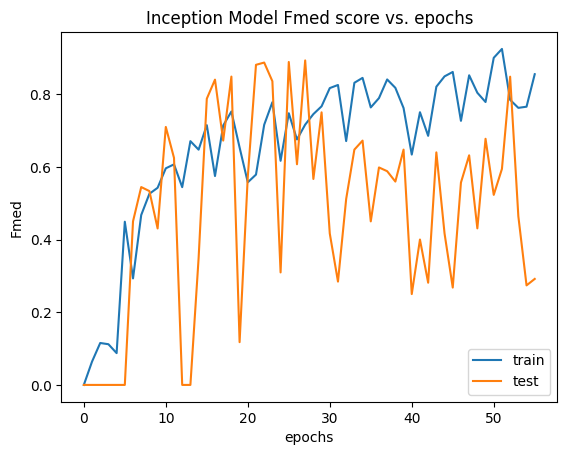

In [ ]:
# summarize history for fmed score
plt.plot(history.history['fmed'])
plt.plot(history.history['val_fmed'])
plt.title('Inception Model Fmed score vs. epochs')
plt.ylabel('Fmed')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

**Summarize history for sensitivity score**

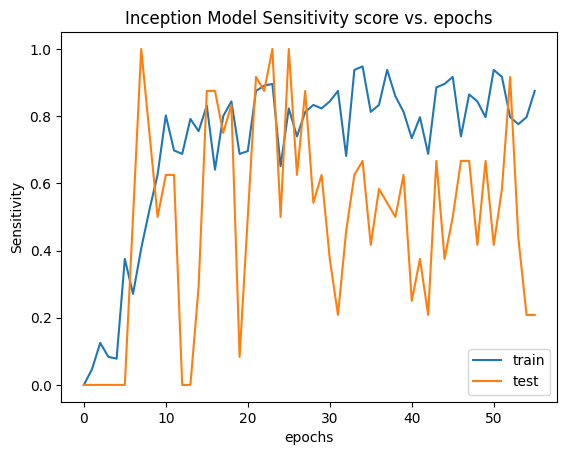

In [ ]:
# summarize history for sensitivity score
plt.plot(history.history['sensitivity'])
plt.plot(history.history['val_sensitivity'])
plt.title('Inception Model Sensitivity score vs. epochs')
plt.ylabel('Sensitivity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

**summarize history for specificity score**

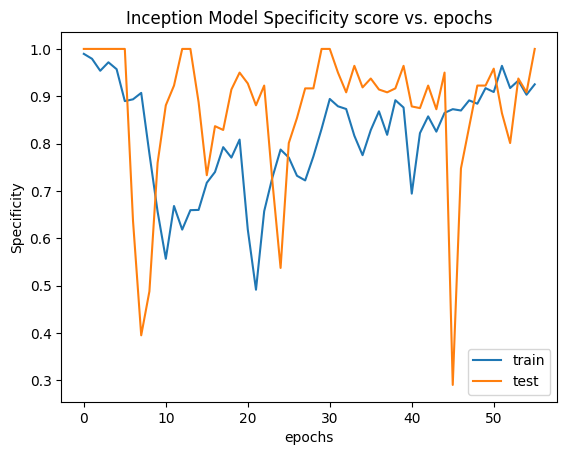

In [ ]:
# summarize history for specificity score
plt.plot(history.history['specificity'])
plt.plot(history.history['val_specificity'])
plt.title('Inception Model Specificity score vs. epochs')
plt.ylabel('Specificity')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

**summarize history for f1 score**

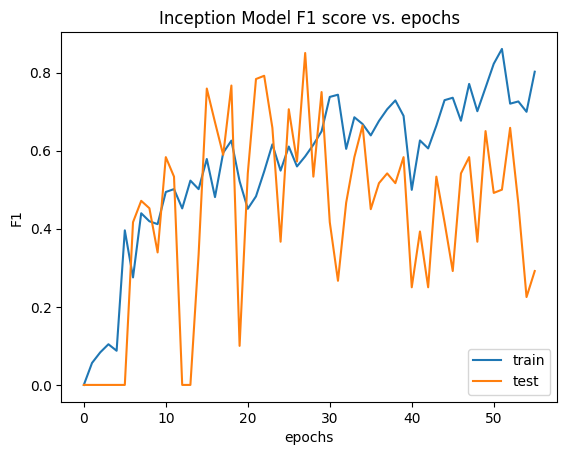

In [ ]:
# summarize history for f1 score
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Inception Model F1 score vs. epochs')
plt.ylabel('F1')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

**summarize history for accuracy**

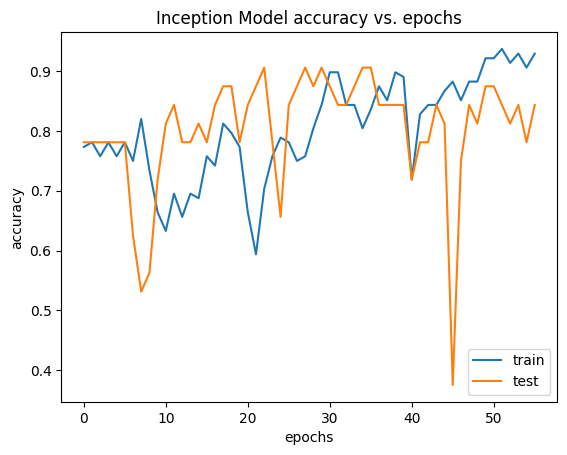

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Inception Model accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()



**Summarise history for loss**

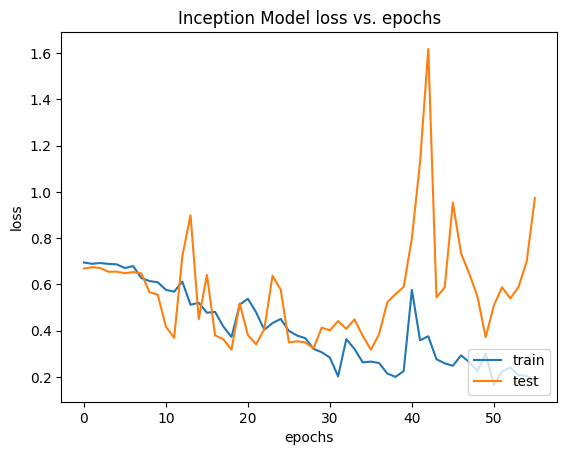

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Inception Model loss vs. epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir_path,
        target_size=(image_height, image_width),
        batch_size=8,
        color_mode="rgb",
        class_mode='binary',
        shuffle=True,
)

Found 32 images belonging to 2 classes.


In [ ]:
results = model_inception.evaluate(test_generator)
print(f"test_loss = {results[0]}")
print(f"test_accuracy = {results[1]}")
print(f"test_sensitivity = {results[2]}")
print(f"test_specificity = {results[3]}")
print(f"test_fmed = {results[4]}")
print(f"test_f1_score = {results[5]}")

4/4 [==============================] - 0s 82ms/step - loss: 0.1440 - accuracy: 0.9688 - sensitivity: 1.0000 - specificity: 0.9643 - fmed: 0.9808 - f1: 0.9167
test_loss = 0.14403672516345978
test_accuracy = 0.96875
test_sensitivity = 0.9999999403953552
test_specificity = 0.9642857313156128
test_fmed = 0.980769157409668
test_f1_score = 0.916666567325592
